In [1]:
# Importing packages
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping

# Importing Pauli matrices
from pauli_matrices.pauli_matrices import I, X, Y, Z

# Importing figure properties
from figure_test_files.figure_properties import *

# Importing functions
from Bell_operator.Bell_operator import get_Bell_terms
from Bell_operator.coefficients import get_coefficients
from classical_optimization.classical_optimization import classical_optimization
from correlation_matrix.correlation_matrix import get_correlation_matrix

# Defining saving directory
save_dir = '../data/figures/'


In [2]:
def calc_classical_bound(theta, H, N, m, basis, extra_Z_gate):

    # Obtaining the general correlation matrix
    M = get_correlation_matrix(theta, N, m, basis=basis, extra_Z_gate=extra_Z_gate)

    # Calcuating a list containing all the possible matrices from kronecker products of the observables in the correlation matrix
    Bell_terms, indices = get_Bell_terms(M, N, m)

    # Calculating the coefficients
    coeffs = get_coefficients(Bell_terms, H, N)

    # Calculating and returning the classical bound 
    return classical_optimization(coeffs, indices, N, m)


In [1]:
# Importing packages
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping

# Importing Pauli matrices
from pauli_matrices.pauli_matrices import I, X, Y, Z

# Importing figure properties
from figure_test_files.figure_properties import *

# Importing functions
from Bell_operator.Bell_operator import get_Bell_terms
from Bell_operator.coefficients import get_coefficients
from classical_optimization.classical_optimization import classical_optimization
from classical_optimization.classical_bound import calc_classical_bound
from correlation_matrix.correlation_matrix import get_correlation_matrix

# Defining saving directory
save_dir = '../data/figures/'

In [3]:
# Defining the number of qubits
N = 2

# Defining the Hamiltonian
H = np.sqrt(2)*(np.kron(Z, Z) + np.kron(X, X))

# Calculating the eigenvalues and eigenstates
eig_vals, eig_vecs = np.linalg.eigh(H)

# extracting the ground state energy and the respective eigenstate
psi_G = eig_vecs[:,0]
psi_G_dagger = np.conjugate(np.transpose(psi_G))

In [118]:
# Defining number of measurements and the angles of the N*m-1 measurements
m = 2
alpha = np.pi-1e-10
theta = [alpha, np.pi/4, alpha]

# Initializing basis and extra Z gate
basis = 'XZ'
extra_Z_gate = False

# Obtaining the general correlation matrix
M = get_correlation_matrix(theta, N, m, basis=basis, extra_Z_gate=True)

# Adding one to number of measurements to account for the extra z_gate
if extra_Z_gate:
    m += 1

# Calcuating a list containing all the possible matrices from kronecker products of the observables in the correlation matrix
Bell_terms, indices = get_Bell_terms(M, N, m)

# Calculating the coefficients
coeffs = get_coefficients(Bell_terms, H, N)

# Calculating the classical bound
beta_C = classical_optimization(coeffs, indices, N, m)
beta_C


-68284181965.35585

In [119]:
# Initializing the Bell operator
B = np.zeros((2**N, 2**N), dtype='complex128')

# Adding terms to the Bell operator
for j in range(len(coeffs)):
    B += coeffs[j]*Bell_terms[j]

# Calculating the difference between the Bell operator and the Hamiltonian
# print(np.sum(np.abs(B-H), axis=(0,1)))

# Calculting the quantum value
beta_Q = np.matmul(psi_G_dagger, np.matmul(B, psi_G))
np.real(beta_Q)

-2.8284420017041496

In [9]:
# # Defining the number of measurements
# m = 2

# # Defining angles
# angles = np.linspace(0, 2*np.pi, 1000)

# # Initializing classical bound
# beta_C = []

# # Calculating classical bounds
# for theta in tqdm(angles):

#     # Obtaining the classical bound with the recursive algorithm
#     beta_C.append( calc_classical_bound(theta, H, N, m, 'XZ', False) )


# fig, ax = plt.subplots()
# ax.plot(angles, beta_C)
# ax.set_xlabel(r'$\theta$')
# ax.set_ylabel(r'$\beta_C$')
# ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
# ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3 \pi}{2}$', r'$2\pi$']);
# fig.savefig(save_dir + 'classical_bound_toy_model_m_%0f.png' %(m), dpi = 300, bbox_inches='tight');


In [120]:
# Defining the number of measurements
m = 2

# Initializing empty list beta_C for call_back function
beta_C = []

# Defining angles
eps = 1e-2
init_guess = np.random.rand(N*m-1)*(np.pi-2*eps)+eps

# Defining arguments
basis = 'XZ'
extra_Z_gate = False
args = (H, N, m, basis, extra_Z_gate)

# Defining minimization options
options = {
        'maxiter'  : 2000,
}

# Defining a fitting function and a callback function
def fitting_func(theta, H, N, m, basis, extra_Z_gate):

    return -calc_classical_bound(theta, H, N, m, basis, extra_Z_gate)

def callback_function(theta):

    beta_C.append( calc_classical_bound(theta, H, N, m, basis, extra_Z_gate) )


# Defining the minimizer keyword arguments
minimizer_kwargs = {
                'method'  : "Nelder-Mead",
                'args'    : args,
                'options' : options,
                'callback': callback_function
}

res = basinhopping(fitting_func, init_guess,
                minimizer_kwargs = minimizer_kwargs,
                niter = 10,
                # disp = True
)



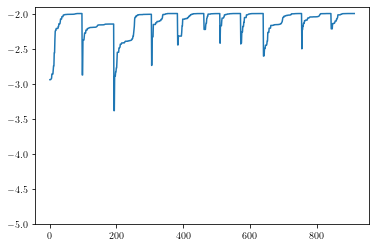

In [121]:
fig, ax = plt.subplots()
ax.plot( np.linspace(1, len(beta_C), len(beta_C)), np.array(beta_C) )
ax.set_ylim((-5, -1.9));

In [110]:
np.max(beta_C)

-2.00002045726312